In [1]:
import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

%matplotlib inline
pd.set_option('display.max_colwidth', 300)

In [2]:
#meta = pd.read_csv("df2.csv", sep = '\t')
meta = pd.read_csv("dfxx.csv", sep = '\t')
meta.head()

,ID_Post,Headline,Body,Status,ArgumentsUsed,Discriminating,Inappropriate,OffTopic,PersonalStories,PossiblyFeedback,SentimentNegative,SentimentNeutral,SentimentPositive,HeadBody,new_labels
0,432258,NaN,"Das kann man nur mutmaßen, aber nicht erkennen. Könnten genauso gut einfach Dreckspritzer sein.",online,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SentimentNeutral,NaN,"Das kann man nur mutmaßen, aber nicht erkennen. Könnten genauso gut einfach Dreckspritzer sein.",online SentimentNeutral
1,136446,NaN,Sorry für die verursachte Mühe der Löschungen.,deleted,NaN,NaN,NaN,NaN,NaN,NaN,SentimentNegative,NaN,NaN,Sorry für die verursachte Mühe der Löschungen.,deleted SentimentNegative
2,136458,NaN,"Witzig, dass der Poster selber nicht widersprochen hat. :-)",online,NaN,NaN,NaN,OffTopic,NaN,NaN,NaN,SentimentNeutral,NaN,"Witzig, dass der Poster selber nicht widersprochen hat. :-)",online OffTopic SentimentNeutral
3,136457,NaN,Foggwulf und Mouilly haben es Ihnen ja schon erklärt und ihre richtige Interpretation dargelegt.\r\n\r\nAuch bei diesem Posting bitte wieder anwenden ;),online,ArgumentsUsed,NaN,NaN,NaN,NaN,NaN,NaN,SentimentNeutral,NaN,Foggwulf und Mouilly haben es Ihnen ja schon erklärt und ihre richtige Interpretation dargelegt.\r\n\r\nAuch bei diesem Posting bitte wieder anwenden ;),online ArgumentsUsed SentimentNeutral
4,136456,NaN,"was auch erklärt, warum körperlich schwächere frauen die stärkeren männer verletzen können.\r\ntrotzdem kann ein schlag von einem mann ohne diese schranke, an einer frau mehr anrichten, als umgekehrt der schlag einer frau,\r\npsychische gewalt ist immer auch teil der körperlichen, da wird abgewe...",online,ArgumentsUsed,NaN,NaN,NaN,NaN,NaN,NaN,SentimentNeutral,NaN,"was auch erklärt, warum körperlich schwächere frauen die stärkeren männer verletzen können.\r\ntrotzdem kann ein schlag von einem mann ohne diese schranke, an einer frau mehr anrichten, als umgekehrt der schlag einer frau,\r\npsychische gewalt ist immer auch teil der körperlichen, da wird abgew...",online ArgumentsUsed SentimentNeutral


In [3]:
meta['ID_Post'] = meta['ID_Post'].astype(str)
meta['HeadBody'] = meta['HeadBody'].astype(str)

In [4]:
# function for text cleaning 
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

In [5]:
nltk.download('punkt')
nltk.download('stopwords')

stemmer = SnowballStemmer("german")
stop_words = set(stopwords.words("german"))


def clean_text(text, for_embedding=False):
    """
        - remove any html tags (< /br> often found)
        - Keep only ASCII + European Chars and whitespace, no digits
        - remove single letter chars
        - convert all whitespaces (tabs etc.) to single wspace
        if not for embedding (but e.g. tdf-idf):
        - all lowercase
        - remove stopwords, punctuation and stemm
    """
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    if for_embedding:
        # Keep punctuation
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)

    word_tokens = word_tokenize(text)
    words_tokens_lower = [word.lower() for word in word_tokens]
    words_filtered = words_tokens_lower
    text_clean = " ".join(words_filtered)
    return text_clean

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Tariki\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tariki\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
meta['cleantext'] = meta['HeadBody'].apply(lambda x: clean_text(x))

In [7]:
meta["cleantext"]

0                                                                                                                                                                                                                      das kann man nur mutmaßen aber nicht erkennen könnten genauso gut einfach dreckspritzer sein
1                                                                                                                                                                                                                                                                     sorry für die verursachte mühe der löschungen
2                                                                                                                                                                                                                                                             witzig dass der poster selber nicht widersprochen hat
3                                                                           

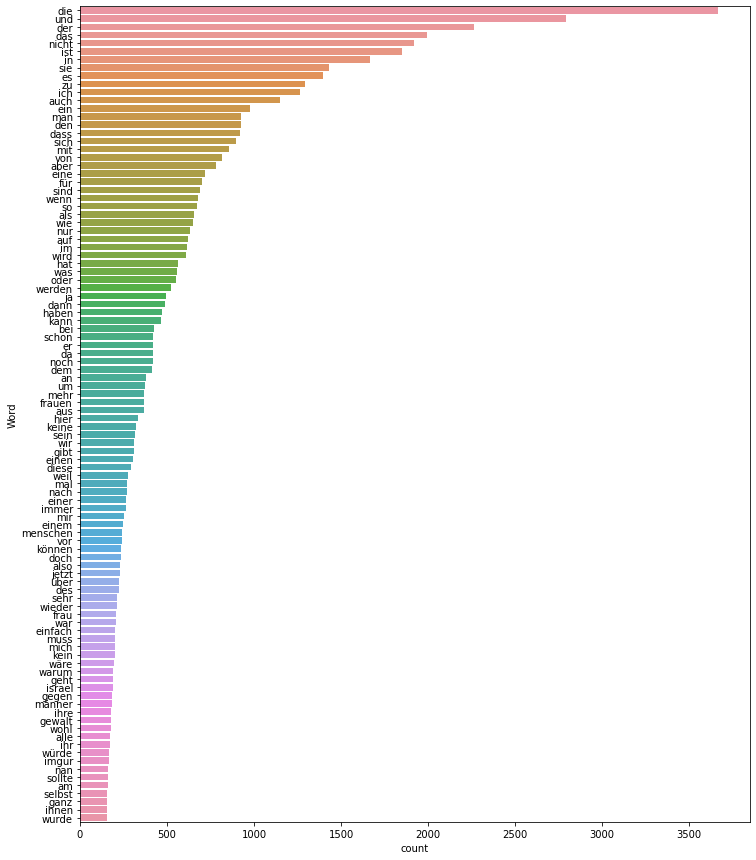

In [8]:
def freq_words(x, terms = 30): 
    all_words = ' '.join([text for text in x]) 
    all_words = all_words.split() 
    fdist = nltk.FreqDist(all_words) 
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
    # selecting top 20 most frequent words 
    d = words_df.nlargest(columns="count", n = terms) 
  
    # visualize words and frequencies
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=d, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    plt.show()

#print 100 most frequent words 
freq_words(meta['cleantext'], 100)

In [9]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('german'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

meta['cleantext'] = meta['cleantext'].apply(lambda x: remove_stopwords(x))

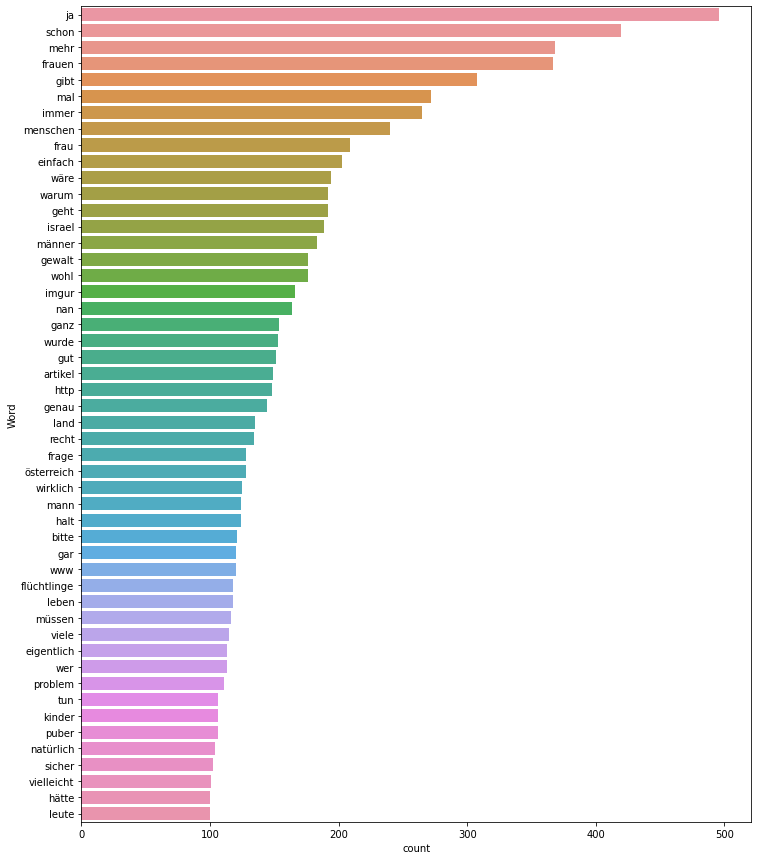

In [10]:
freq_words(meta['cleantext'], 50)

In [11]:
meta['new_labels'][0]

'online        SentimentNeutral '

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(meta['new_labels'])

# transform target variable
y = multilabel_binarizer.transform(meta['new_labels'])

In [13]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.7, max_features=200)

In [14]:
# split dataset into training and validation set
xtrain, xval, ytrain, yval = train_test_split(meta['cleantext'], y, test_size=0.3, random_state=9)

In [15]:
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

In [16]:
from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score

In [17]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

In [18]:
# fit model on train data
clf.fit(xtrain_tfidf, ytrain)

C:\ProgramData\Anaconda3\envs\intro2nlp\lib\site-packages\sklearn\multiclass.py:77: UserWarning: Label 0 is present in all training examples.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\intro2nlp\lib\site-packages\sklearn\multiclass.py:77: UserWarning: Label 8 is present in all training examples.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\intro2nlp\lib\site-packages\sklearn\multiclass.py:77: UserWarning: Label 15 is present in all training examples.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\intro2nlp\lib\site-packages\sklearn\multiclass.py:77: UserWarning: Label 18 is present in all training examples.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\intro2nlp\lib\site-packages\sklearn\multiclass.py:77: UserWarning: Label 20 is present in all training examples.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\intro2nlp\lib\site-packages\sklearn\multiclass.py:77: UserWarning: Label 21 is present in all training examples.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\intro2nlp\li

OneVsRestClassifier(estimator=LogisticRegression())

In [19]:
# make predictions for validation set
y_pred = clf.predict(xval_tfidf)

In [20]:
y_pred

array([[1, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 1, 0, 0]])

In [21]:
y_pred[3]

array([1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 0])

In [22]:
multilabel_binarizer.inverse_transform(y_pred)[0]

(' ', 'N', 'S', 'a', 'e', 'g', 'i', 'l', 'm', 'n', 'o', 'r', 't', 'v')

In [23]:
# evaluate performance
f1_score(yval, y_pred, average="micro")

0.8387708050405837

In [24]:
# predict probabilities
y_pred_prob = clf.predict_proba(xval_tfidf)

In [25]:
def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

In [26]:
for i in range(5): 
    k = xval.sample(1).index[0] 
    print("Kommentar: ", meta['HeadBody'][k], "\nPredicted Label: ", infer_tags(xval[k])), print("Actual Label: ",meta['new_labels'][k], "\n")

Kommentar:   aha. ihre erfahrung ist also, dass jemand einen blog vorstellt, etwas als thema anspricht und dies dann nicht mehr erwähnt. das ist ihnen scheinbar schon so oft passiert, dass sie grundsätzlich eher erwarten, dies würde passieren, anstatt, wie das wohl die meisten menschen tun würden, davon auszugehen, dass die autorin weiss, worüber sie bloggen wird.

sie tun dies trotz der tatsache, dass der ursprüngliche kommentar bereits 2 links zu untersuchungen einer durchaus unverdächtigen institution enthält. man könnte über die interpretation dieser studien diskutieren, aber wenn sie die existenz der studien nicht zur kenntnis nehmen wollen, muss ich wohl vermuten, das sich das bei ihnen nicht auszahlen wird. 
Predicted Label:  [(' ', 'N', 'S', 'a', 'e', 'g', 'i', 'l', 'm', 'n', 'o', 'r', 't')]
Actual Label:  deleted       SentimentNegative   

Kommentar:  Ich finde die Naivität bei diesem Thema erschreckend. Die Geschichten klingen ha immer herzerwärmend , halten aber meist einem